In [1]:
from helper.dataset_reader import read_tsv
from helper.data_transformer import *
#from helper.utils import *
from ner_crf_3 import *
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn_crfsuite import metrics

In [2]:
ner = NamedEntityRecognition()

In [3]:
#merged_data = read_tsv('../dataset/comlid-data-140422-v1.tsv')

train_data = read_tsv('../dataset/train.tsv')
val_data = read_tsv('../dataset/val.tsv')
test_data = read_tsv('../dataset/test.tsv')

In [4]:
train_data = to_token_tag_list(train_data)
val_data = to_token_tag_list(val_data)
test_data = to_token_tag_list(test_data)

In [5]:
def get_features(data):
	X = [ner.sent2features(s) for s in data]
	y = [ner.sent2tags(s) for s in data]

	return X, y

In [6]:
X_train, y_train = get_features(train_data)
X_val, y_val = get_features(val_data)
X_test, y_test = get_features(test_data)

In [7]:
print(f"Train set: {len(X_train)} sentences")
print(f"Val set: {len(X_val)} sentences")
print(f"Test set: {len(X_test)} sentences")

Train set: 4556 sentences
Val set: 1139 sentences
Test set: 2805 sentences


### CRF Training

In [8]:
model = sklearn_crfsuite.CRF(
	algorithm='lbfgs',
	max_iterations=100,
	all_possible_transitions=True,
	c1=0.1,  # Coefficient for Lasso (L1) regularization for
    c2=0.1,  # Coefficient for Ridge (L2) regularization
)

In [9]:
# train CRF
%time
model.fit(X=X_train, y=y_train, X_dev=X_val, y_dev=y_val)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [10]:
y_pred = model.predict(X_test)

In [11]:
# save model
model_name = 'crf_model_split_3.pkl'
root_path = 'model/'
joined_path = os.path.join(root_path, model_name)
pickle.dump(model, open(joined_path, 'wb'))


 Evaluation on the test data
Confusion Matrix
              precision    recall  f1-score   support

           O     0.9783    0.9941    0.9861     56762
   I-PURPOSE     0.7955    0.6374    0.7077       946
  I-HERITAGE     0.8050    0.6672    0.7296       631
   I-NATURAL     0.8302    0.6094    0.7029       658
   B-PURPOSE     0.8167    0.5863    0.6826       585
  B-HERITAGE     0.8344    0.6267    0.7158       434
   B-NATURAL     0.8404    0.6052    0.7037       618

    accuracy                         0.9704     60634
   macro avg     0.8429    0.6752    0.7469     60634
weighted avg     0.9680    0.9704    0.9683     60634



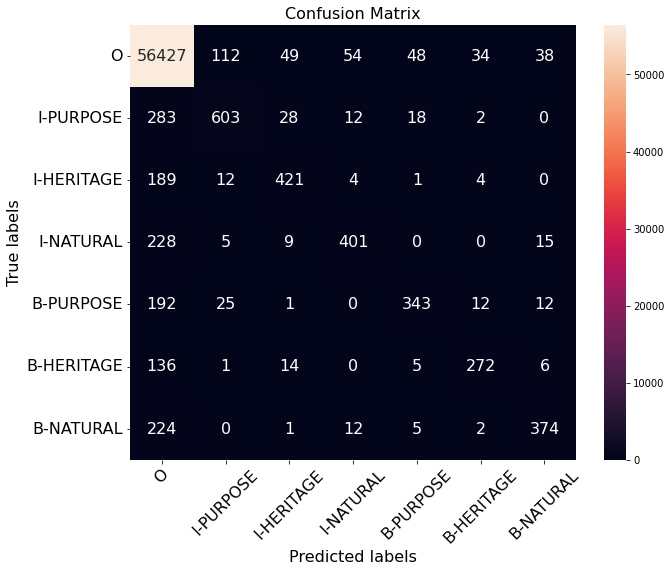

In [12]:
print('\n Evaluation on the test data')
ner.show_confusion_matrix(y_test, y_pred)

# increase font of x and y axis

In [13]:
print("\nTop likely transitions:")
ner.print_transitions(Counter(model.transition_features_).most_common(20))
print("\nTop unlikely transitions:")
ner.print_transitions(Counter(model.transition_features_).most_common()[-20:])

# check the state features
print("\nTop positive:")
ner.print_state_features(Counter(model.state_features_).most_common(20))
print("\nTop negative:")
ner.print_state_features(Counter(model.state_features_).most_common()[-20:])


Top likely transitions:
O          -> O          5.55065
B-PURPOSE  -> I-PURPOSE  4.59685
B-NATURAL  -> I-NATURAL  4.16368
B-HERITAGE -> I-HERITAGE 4.08130
I-HERITAGE -> I-HERITAGE 3.74263
I-PURPOSE  -> I-PURPOSE  3.68328
I-NATURAL  -> I-NATURAL  3.06220
O          -> B-NATURAL  2.09949
O          -> B-PURPOSE  2.06824
O          -> B-HERITAGE 2.00240
I-HERITAGE -> O          0.91412
I-NATURAL  -> O          0.80211
I-PURPOSE  -> O          0.69923
I-HERITAGE -> B-HERITAGE 0.03631
I-NATURAL  -> B-NATURAL  -0.19981
B-PURPOSE  -> O          -0.36595
B-NATURAL  -> O          -0.39740
B-HERITAGE -> O          -0.51536
I-PURPOSE  -> B-PURPOSE  -0.81626
B-NATURAL  -> B-NATURAL  -1.65223

Top unlikely transitions:
B-PURPOSE  -> B-HERITAGE -2.28571
B-PURPOSE  -> I-NATURAL  -2.29837
I-HERITAGE -> I-PURPOSE  -2.33401
B-PURPOSE  -> I-HERITAGE -2.34267
I-PURPOSE  -> B-NATURAL  -2.34570
B-HERITAGE -> I-NATURAL  -2.44728
O          -> I-NATURAL  -2.47459
B-NATURAL  -> I-HERITAGE -2.48084
I-NATURAL 

In [14]:
import eli5

eli5.show_weights(model,horizontal_layout=False, show=['transition_features'])

From \ To,O,B-HERITAGE,I-HERITAGE,B-NATURAL,I-NATURAL,B-PURPOSE,I-PURPOSE
O,5.551,2.002,-3.433,2.099,-2.475,2.068,-3.066
B-HERITAGE,-0.515,-2.718,4.081,-2.614,-2.447,-2.841,-2.601
I-HERITAGE,0.914,0.036,3.743,-1.885,-2.104,-2.017,-2.334
B-NATURAL,-0.397,-2.63,-2.481,-1.652,4.164,-2.936,-2.607
I-NATURAL,0.802,-2.236,-2.219,-0.2,3.062,-2.496,-3.078
B-PURPOSE,-0.366,-2.286,-2.343,-1.975,-2.298,-1.914,4.597
I-PURPOSE,0.699,-1.914,-2.551,-2.346,-2.204,-0.816,3.683


In [15]:
eli5.show_weights(model, targets=['O','B-HERITAGE','I-HERITAGE'])

In [16]:
eli5.show_weights(model, targets=['B-NATURAL','I-NATURAL','B-PURPOSE','I-PURPOSE'])